# Prototype Version 3
This code will read data from an tsv file, this file contains associations of the name of a tandem spectra and their corresponding amino acids sequence. I will find the corresponding spectra in an mzML file. This code will then <b>visualize</b> spectra and <b>identify</b> the peaks. Based on the distances between the peaks (which are assumed to be y-ions) the code will <b>recognize</b> amino acids that could fit in between these peaks. These puzzle pieces are given a confidence score referring to their likelyhood of being part of the full peptide.
<br>
 finally a code will combine these puzzle pieces into the most likely amino acids sequence and present in in a human readable way.
<br>
this will be done using the <b>DeNovo </b> approach presented by Nick Webb (https://www.weddslist.com/ms/tandem.html)

I will investigate how well my programs predict the amino acid sequence by comparing the actual vs predicted sequence.

At the end, in order to check my results, I will use the pyteomics.pylab_aux module to test my annotations and visualize the annotated spectrum.

In [1]:
import ast

# basic dependencies and useful math/organization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# to read mzML files
from pyteomics import mzml

# to visualize mzML
from pyteomics import pylab_aux as pa, usi

# to find peaks
from scipy.signal import find_peaks
from peakutils import indexes

## reading the files

In [2]:
# file that contains the associations between tandem spectra name and amino acids sequence
df = pd.read_csv("../data/psm_a.tsv", sep="\t")

In [3]:
df.head()

,Spectrum,Spectrum File,Peptide,Modified Peptide,Extended Peptide,Prev AA,Next AA,Peptide Length,Charge,Retention,...,Protein Description,Mapped Genes,Mapped Proteins,Parent Scan Number,Apex Retention Time,Apex Scan Number,Retention Time Start,Retention Time End,Retention Time FWHM,Traced Scans
0,2015-05-19_MRC5_a.05045.05045.4,interact.pep.xml,VHGPGIQSGTTNKPNK,NaN,GCDPSRVR.VHGPGIQSGTTNKPNK.FTVETRGA,R,F,16,4,833.6553,...,Filamin-A,NaN,NaN,5044,837.50806,5075,820.00700,860.02106,14.907001,66
1,2015-05-19_MRC5_a.05137.05137.3,interact.pep.xml,YHTVNGHNCEVR,YHTVNGHNCEVR,VDKIVIQK.YHTVNGHNCEVR.KALSKQEM,K,K,12,3,848.0802,...,Heterogeneous nuclear ribonucleoprotein A1,HNRNPA1L3,sp|A0A2R8Y4L2|RA1L3_HUMAN,5134,0.00000,0,0.00000,0.00000,0.000000,0
2,2015-05-19_MRC5_a.05268.05268.3,interact.pep.xml,NQTAEKEEFEHQQK,NaN,EIINWLDK.NQTAEKEEFEHQQK.ELEKVCNP,K,E,14,3,867.4215,...,Heat shock cognate 71 kDa protein,NaN,NaN,5267,855.37700,5188,834.13904,922.82404,20.950000,133
3,2015-05-19_MRC5_a.05273.05273.3,interact.pep.xml,RDHALLEEQSK,NaN,KVQQLVPK.RDHALLEEQSK.QQSNEHLR,K,Q,11,3,868.4587,...,Alpha-actinin-4,NaN,NaN,5272,873.95000,5310,860.02106,902.49304,17.305000,63
4,2015-05-19_MRC5_a.05307.05307.3,interact.pep.xml,IECDDKGDGSCDVR,IECDDKGDGSCDVR,VEGPSQAK.IECDDKGDGSCDVR.YWPQEAGE,K,Y,14,3,873.5540,...,Filamin-A,FLNC,sp|Q14315|FLNC_HUMAN,5306,860.02106,5221,830.17100,912.24900,16.953001,118


In [4]:
# file that contains the amino acids and their weights
# TODO for now there is a distinction between "I" and "L"
# They are indistinguishable by weight so I cant really know which one it is
aa = pd.read_csv("../data/single_double_amino_acids.csv")

In [5]:
mz_path = '../data/2015-05-19_MRC5_a.mzML'

In [6]:
# this creates a dictionary of matches between the mzMl file and the psm_a.tsv
# this should only return MS/MS where we have the Peptide sequence already identified.
i = 0
matches = []
plotting_dict = None
with mzml.MzML(mz_path) as reader:
    for spectrum in reader:
        # looking for the first match between the 2 files
        for name in df["Spectrum"]:
            if name in spectrum.get('spectrum title') :
                # print(spectrum["index"], spectrum.get("spectrum title"))
                # Extract relevant information
                matches.append([spectrum,df[df["Spectrum"] == name]["Peptide"].sum(),
                               df[df["Spectrum"] == name]["Hyperscore"].sum()])
                """
                spectrum_name = name
                mz_array = spectrum['m/z array']
                intensity_array = spectrum['intensity array']
                precursor_mz = (spectrum['precursorList']['precursor']
                                [0]['selectedIonList']['selectedIon'][0]['selected ion m/z'])

                plotting_dict = {'m/z array': mz_array, 'intensity array': intensity_array}
                """
        #         break
        # if plotting_dict != None:
        #     break
m_df = (pd.DataFrame(matches, columns=["Spectrum","Peptide","Hyperscore"])
    .sort_values(by = ["Hyperscore"], axis=0, ascending= False)
    .reset_index(drop=True))

# exec time 2 ~ 3 minutes

In [7]:
#m_df.to_csv("spectrum_peptide_matches.csv", index=False)

In [8]:
m_df["Spectrum"]

0        {'index': 24168, 'id': 'controllerType=0 contr...
1        {'index': 16758, 'id': 'controllerType=0 contr...
2        {'index': 20733, 'id': 'controllerType=0 contr...
3        {'index': 29352, 'id': 'controllerType=0 contr...
4        {'index': 26551, 'id': 'controllerType=0 contr...
                               ...                        
10203    {'index': 30774, 'id': 'controllerType=0 contr...
10204    {'index': 31100, 'id': 'controllerType=0 contr...
10205    {'index': 31003, 'id': 'controllerType=0 contr...
10206    {'index': 10026, 'id': 'controllerType=0 contr...
10207    {'index': 30787, 'id': 'controllerType=0 contr...
Name: Spectrum, Length: 10208, dtype: object

In [9]:
# Peptide Sequence to find
peptide = m_df["Peptide"].iloc[0]
print("Peptide sequence:", peptide)
mz_array = m_df["Spectrum"].iloc[0]['m/z array']
intensity_array = m_df["Spectrum"].iloc[0]['intensity array']
precursor_mz = m_df["Spectrum"].iloc[0]['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z']
plotting_dict = {'m/z array': mz_array, 'intensity array': intensity_array}


Peptide sequence: VIHDNFGIVEGLMTTVHAITATQK


## Finding Peaks

In [10]:
s1 = pd.DataFrame(plotting_dict)
# pa.plot_spectrum(s1)

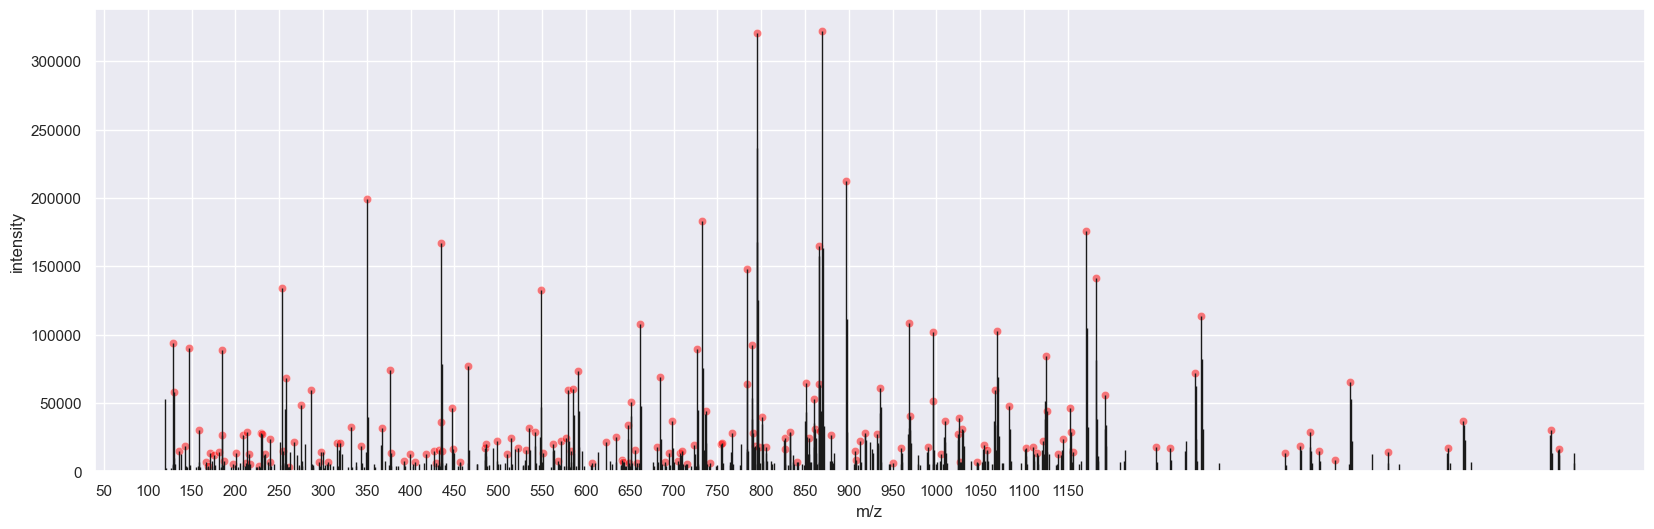

<Figure size 1200x600 with 0 Axes>

In [11]:
sp_height = None
sp_dist = None
sp_prom = None
#TODO find ways to optimize for these parameters, possible based on characteristics of each spectrum
# i.e.: based on how long we expect the amino acid sequence to be
# what determines wheter a peak is useful, is there someway we can find out?
# 

sci_peak, _ = find_peaks(s1["intensity array"],
                      height=sp_height,
                      distance=sp_dist,
                      prominence=sp_prom
                      )
sns.set_theme(rc={'figure.figsize':(20,6)})
sns.scatterplot(data = s1.iloc[sci_peak].reset_index(),
                x = "m/z array",
                y = "intensity array",
                color = "red", alpha = 0.5).set_xticks(np.arange(0,1200,50))
pa.plot_spectrum(plotting_dict)
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.figure(figsize=(12,6))
plt.show()

## annotating the spectra with pyteomics

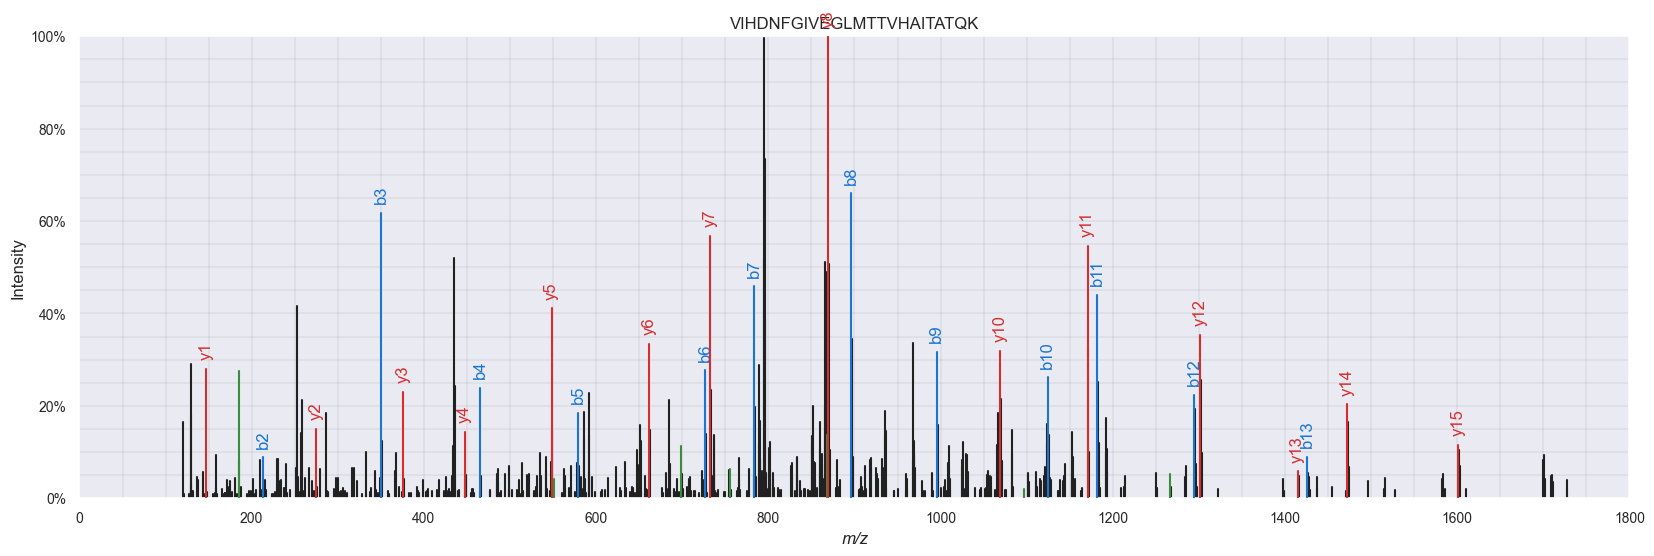

24

In [12]:
pa.annotate_spectrum(plotting_dict, peptide, precursor_charge=2, backend='spectrum_utils',
    ion_types='aby', title=peptide)
plt.show()
len(peptide)

## Finding the sequence

In [13]:
# import importlib
# import other_files.my_funcs as mine
# importlib.reload(mine)
# from other_files.my_funcs import find_aa_seq

In [14]:
# normalize all the peaks to percentages
percentage_int = intensity_array/np.max(intensity_array) * 100

In [15]:
# cheesing an issue with the apply function
combo_df = aa

In [16]:
import math
def find_closest_aa(value, thres = 5):
    """ Find the closest amino acid to a given mass.
    this code takes a dataframe with single amino acids and combinations of amino acids in this format

        full    letter  short   comp    mono    mass    G           A           S           P   V etc.
    0   glycine G       gly     c2h3no  57      57      g+g mass    g+a mass    g+s mass
    1   alanine A       ala     c3h5no  71      71      a+g mass    a+a mass    a+s mass
    etc.

    using this dataframe and a given mass, it will find the closest amino acid
     or combination of 2 amino acids to the given mass.
    It will only return amino acids that are within the threshold.
    It returns a list of lists, where each list contains the letter of the amino acid, its mass and the error.
    """
    if math.isnan(value) == True:
        return None
    single_df = combo_df.iloc[:,:-22]
    double_df = combo_df.set_index(["letter"]).iloc[
                :,[i for i in range(-22, -0)]]
    closeness_list = []
    # find the closest single amino acids
    loop_for_single = True
    while loop_for_single:
        aam_array = np.asarray(single_df["mono mass"])
        idx = (np.abs(aam_array - value)).argmin()
        error = np.abs(aam_array[idx] - value)
        if error > thres:
            loop_for_single = False
        else:
            name_idx = single_df["letter"].iloc[idx]
            closeness_list.append([name_idx, aam_array[idx], error])
            single_df = single_df.drop(single_df.index[idx])
    # find closest combination of amino acids
    loop_for_combo = True
    while loop_for_combo:
        error = (np.abs(double_df - value)).min().min()
        r, c = np.where(double_df == error + value)
        # if error wouldve been negative np.where will not find r, c
        # and pass empty arrays creating error
        if r.size == 0 :
            # print("boink")
            r, c = np.where(double_df == value - error)
        if error > thres:
            loop_for_combo = False
        else:
            name_idx = double_df.index[r[0]]+ "+" + double_df.columns[c[0]]
            closeness_list.append([name_idx, double_df.iloc[r[0],c[0]], error])
            double_df.iloc[r[0],c[0]] = None
    # print("closest aa is: ", name_idx, " ,with mass: ",
    # aam_array[idx], "Da. With an error of: ", error, "Da.")
    closeness_list.sort(key=lambda x: x[2])
    if closeness_list:
        return closeness_list[0]
    return None


'''
I would love to decided a closeness factor by iterating over the weights
and seeing how close they are to each other on average. Does this make sense?
'''

'\nI would love to decided a closeness factor by iterating over the weights\nand seeing how close they are to each other on average. Does this make sense?\n'

In [23]:
# on my stackoverflow someone suggested a better way to create my distance matrix
# however I am now so deep in this going back would cost too much time

# this code builds a distance matrix for the given mz_array
# unless there is already a file in the directory it can just read

def rename(column):
    new = mz_array[int(column)]
    return new

try:
    df_aa = pd.read_csv("example_matrix_named.csv").set_index("Unnamed: 0")
except:
    distance_matrix = []
    for column, i in zip(mz_array, range(len(mz_array))):
        distance_matrix.append([])
        for row in mz_array:
            distance_matrix[i].append(np.abs(row - column))

    mz_strings = np.round(mz_array, decimals= 6)
    df_dm = pd.DataFrame(distance_matrix)
    df_dm.columns = df_dm.columns.map(str)

    # for i in range(len(mz_array)):
    #     for j in range(i):
    #         df_dm.iat[i,j] = None
    for i in range(len(mz_array)):
        for j in range(len(mz_array)):
            if j <= i:
                df_dm.iat[i,j] = None
            if df_dm.iat[i,j] < 55 or df_dm.iat[i,j] > 480:
                df_dm.iat[i,j] = None

    # if j <= i:
    #     df_dm.iat[i,j] = None
    # drop columns with no values (all NaN)
    df_dm.dropna(axis = 1, how="all", inplace = True)

    print("starting mapping")
    df_aa = df_dm.map(find_closest_aa)
    print("mapping complete")

    if df_aa.columns[0] == "32":
        print("boink")
        df_aa.rename(columns=rename, inplace=True)
        df_aa.rename(index=rename, inplace=True)
    else:
        pass

    df_aa.to_csv("example_matrix_named.csv")


In [24]:
# df_aa.drop(columns=["Unnamed: 0"], inplace = True)

In [25]:
# df_aa.to_csv("example_matrix_named.csv", index=False)

In [27]:
df_aa.columns

Index(['175.11891174316406', '177.05743408203125', '181.10855102539062',
       '183.11279296875', '183.150146484375', '185.09268188476562',
       '185.1286163330078', '185.16494750976562', '186.16896057128906',
       '187.0722198486328',
       ...
       '1602.8094482421875', '1609.813720703125', '1699.8795166015625',
       '1700.8857421875', '1701.898681640625', '1708.8660888671875',
       '1709.8887939453125', '1710.880615234375', '1726.9127197265625',
       '1727.895751953125'],
      dtype='object', length=571)

In [29]:
import json

#print(type(df_aa[175.11891174316406].loc[120.08098602294922]))
print(type(ast.literal_eval(df_aa["175.11891174316406"].loc[120.08098602294922])))
#print(type(ast.literal_eval(df_aa[175.11891174316406].loc[175.11891174316406])))

<class 'list'>


In [51]:
print(mz_array[571])
df_aa.iloc[571]

1414.7628173828125


175.11891174316406                                             NaN
177.05743408203125                                             NaN
181.10855102539062                                             NaN
183.11279296875                                                NaN
183.150146484375                                               NaN
                                          ...                     
1708.8660888671875    ['M+Y', 294.10381322, 0.0005417356250063676]
1709.8887939453125       ['G+O', 294.16919066, 0.9567859024999734]
1710.880615234375        ['F+U', 298.02204735, 1.9042494984374798]
1726.9127197265625       ['R+R', 312.2022221, 0.05231975624997176]
1727.895751953125        ['U+Y', 314.01696198, 0.8840274096875191]
Name: 1414.7628173828125, Length: 571, dtype: object

In [42]:
df_aa.index.values

array([ 120.08098602,  121.08407593,  127.08722687,  129.06599426,
        129.0934906 ,  129.1023407 ,  130.0644989 ,  130.07301331,
        130.08641052,  130.10572815,  130.18443298,  131.28944397,
        136.07562256,  138.06578064,  143.11752319,  143.85470581,
        144.63363647,  147.11289978,  148.11611938,  155.08122253,
        157.09675598,  159.04734802,  159.09158325,  160.09461975,
        166.06141663,  167.08195496,  169.06045532,  169.13290405,
        170.90370178,  171.11303711,  173.09239197,  173.12872314,
        175.11891174,  177.05743408,  181.10855103,  183.11279297,
        183.15014648,  185.09268188,  185.12861633,  185.16494751,
        186.16896057,  187.07221985,  195.07585144,  197.12895203,
        199.18106079,  201.12329102,  203.10186768,  205.09976196,
        209.1035614 ,  209.14004517,  211.14440918,  212.10299683,
        213.08621216,  213.12367249,  213.15960693,  214.11795044,
        215.08518982,  215.10346985,  217.13664246,  223.15647

In [37]:
df_aa.loc[233.09417724609375]# 233.09417724609375

KeyError: 233.09417724609375

In [52]:
#def find_path():
path_one = []
cur_peak = float(mz_array[0])
# TODO write code that does this but from the highest peak downwards
while cur_peak < mz_array[-1]:
    for i in df_aa.columns:
        # print("conk", type(aa))
        aa = df_aa[i].loc[cur_peak]
        if isinstance(aa, str) :
            print("boingoloingo")
            path_one.append(aa[0])
            cur_peak = float(i)

print(path_one)

boingoloingo
boingoloingo


KeyError: 233.09417724609375

In [43]:
233.09417724609375


[]

In [62]:
None[0]

<>:1: SyntaxWarning: 'NoneType' object is not subscriptable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'NoneType' object is not subscriptable; perhaps you missed a comma?
C:\Users\TheSh\AppData\Local\Temp\ipykernel_23544\1068451131.py:1: SyntaxWarning: 'NoneType' object is not subscriptable; perhaps you missed a comma?
  None[0]


TypeError: 'NoneType' object is not subscriptable